In [1]:
using Plots
using Statistics
using StatsBase
using Distributions
using PoissonRandom

using LightGraphs, SimpleWeightedGraphs
using GraphPlot

# Functions 

In [29]:
function init_BA(N, k, alpha, prob="Single")
   
    G = barabasi_albert(N, k)
    
    G_weighted = SimpleWeightedGraph(N)

    if prob == "Single"
    
        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), alpha)

        end
        
    elseif prob == "Uniform"
        
        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), rand(1 : 2*alpha-1))

        end
        
    elseif prob == "Poisson"
        
        for edge in collect(edges(G))
        
            add_edge!(G_weighted, src(edge), dst(edge), 1 + pois_rand(alpha - 1))
            
        end
        
    else
        
        println("Probability distribution not implemented")
        
    end

    return G_weighted
    
end

function init_WS(N, k, beta, alpha, prob="Single")
   
    G = watts_strogatz(N, k, beta)
    
    G_weighted = SimpleWeightedGraph(N)
    
    if prob == "Single"

        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), alpha)

        end
        
    elseif prob == "Uniform"
        
        for edge in collect(edges(G))

            add_edge!(G_weighted, src(edge), dst(edge), rand(1 : 2*alpha-1))

        end
        
    elseif prob == "Poisson"
        
        for edge in collect(edges(G))
        
            add_edge!(G_weighted, src(edge), dst(edge), 1 + pois_rand(alpha - 1))
            
        end
        
    end
    
    return G_weighted
    
end

function set_node_states(N, N_inf)
    
    node_type = zeros(N)
    
    rand_nodes = sample(1 : N, N_inf, replace=false)

    for i in 1 : N_inf
        
        r = rand_nodes[i]
    
        node_type[r] = 1
        
    end
    
    return node_type
    
end

function MC_SIS(G, node_dic, lambda, mu)
    
    infected_nodes = []
    susceptible_nodes = []
    
    for node in vertices(G)
    
        if node_dic[node] == 1 #Infected node

            neighbours = neighbors(G, node)
            
            #The infected node can infect each of its neighbours with probability proportional
            #to the edge weights
            for nn in neighbours
                
                if node_dic[nn] == 0 #If the neighbour node is susceptible it could get infected

                    w = G.weights[node, nn]

                    lambda_w = 1 - (1 - lambda)^w

                    if rand() < lambda_w

                        #Infect nn node, but the change in state in the end
                        append!(infected_nodes, nn)

                    end
                    
                end

            end
            
            #Infected node gets recovered with probability mu
            if rand() < mu

                append!(susceptible_nodes, node)

            end

        end

    end
    
    
    for item in infected_nodes
        
        node_dic[item] = 1
        
    end
    
    for item in susceptible_nodes
        
        node_dic[item] = 0
        
    end
    
    return node_dic
    
end

function MC_SIR(G, node_dic, lambda, mu)
    
    infected_nodes = []
    recovered_nodes = []
    
    for node in vertices(G)
    
        if node_dic[node] == 1 #Infected node

            neighbours = neighbors(G, node)
            
            #The infected node can infect each of its neighbours with probability proportional
            #to the edge weights
            for nn in neighbours
                
                if node_dic[nn] == 0 #If the neighbour node is susceptible it could be infected

                    w = G.weights[node, nn]

                    lambda_w = 1 - (1 - lambda)^w

                    if rand() < lambda_w

                        #Infect nn node
                        append!(infected_nodes, nn)

                    end
                    
                end

            end
            
            #Infected node gets recovered with probability mu
            if rand() < mu

                append!(recovered_nodes, node)

            end

        end

    end
    
    for item in infected_nodes
        
        node_dic[item] = 1
        
    end

    for item in recovered_nodes
        
        node_dic[item] = 2
        
    end
    
    return node_dic
    
end

function compute_observables(G, node_dic)
   
    S = 0
    I = 0
    R = 0
    
    for node in vertices(G)
    
        if node_dic[node] == 0
            
            S += 1
            
        elseif node_dic[node] == 1
            
            I += 1
            
        else
            
            R += 1
            
        end
        
    end
    
    return S / nv(G), I / nv(G), R / nv(G)
    
end

function SIS_model_WS(N, N_inf, k, beta, alpha, lambda, mu, t, times, prob="Single")
    
    S = zeros(t)
    I = zeros(t)
    
    for index in 1 : times
        
        G = init_WS(N, k, beta, alpha, prob)
        
        node_dic = set_node_states(N, N_inf)        
    
        for i in 1 : t
            
            obs = compute_observables(G, node_dic)
            
            S[i] += obs[1]
            I[i] += obs[2]
            
            node_dic = MC_SIS(G, node_dic, lambda, mu)

        end
        
    end
    
    return S ./ times, I ./ times
    
end

function SIR_model_WS(N, N_inf, k, beta, alpha, lambda, mu, t, times, prob="Single")
    
    S = zeros(t)
    I = zeros(t)
    R = zeros(t)
    
    for index in 1 : times
        
        G = init_WS(N, k, beta, alpha, prob)
        
        node_dic = set_node_states(N, N_inf)        
    
        for i in 1 : t
            
            obs = compute_observables(G, node_dic)
            
            S[i] += obs[1]
            I[i] += obs[2]
            R[i] += obs[3]
            
            node_dic = MC_SIR(G, node_dic, lambda, mu)

        end
        
    end
    
    return S ./ times, I ./ times, R ./ times
    
end

function SIS_model_BA(N, N_inf, k, alpha, lambda, mu, t, times, prob="Single")
    
    S = zeros(t)
    I = zeros(t)
    
    for index in 1 : times
        
        G = init_BA(N, k, alpha, prob)
        
        node_dic = set_node_states(N, N_inf)        
    
        for i in 1 : t
            
            obs = compute_observables(G, node_dic)
            
            S[i] += obs[1]
            I[i] += obs[2]
            
            node_dic = MC_SIS(G, node_dic, lambda, mu)

        end
        
    end
    
    return S ./ times, I ./ times
    
end

function SIR_model_BA(N, N_inf, k, alpha, lambda, mu, t, times, prob="Single")
    
    S = zeros(t)
    I = zeros(t)
    R = zeros(t)
    
    for index in 1 : times
        
        G = init_BA(N, k, alpha, prob)
        
        node_dic = set_node_states(N, N_inf)        
    
        for i in 1 : t
            
            obs = compute_observables(G, node_dic)
            
            S[i] += obs[1]
            I[i] += obs[2]
            R[i] += obs[3]
            
            node_dic = MC_SIR(G, node_dic, lambda, mu)

        end
        
    end
    
    return S ./ times, I ./ times, R ./ times
    
end

function compute_critical_lambda_SIS_WS(lambdas, N, N_inf, k, beta, alpha, mu, t, times, prob="Single")
   
    i = 0
    lambda_c = 0
    
    for lambda in lambdas
        
        i += 1
       
        S, I = SIS_model_WS(N, N_inf, k, beta, alpha, lambda, mu, t, times, prob);
        
        if I[end] != 0
           
            lambda_c = lambdas[i - 1] 
            
            return lambda_c
            
        end
        
    end
    
    return lambda_c
    
end

function compute_critical_lambda_SIS_BA(lambdas, N, N_inf, k, alpha, mu, t, times, prob="Single")
   
    i = 0
    lambda_c = 0
    
    for lambda in lambdas
        
        i += 1
       
        S, I = SIS_model_BA(N, N_inf, k, alpha, lambda, mu, t, times, prob);
        
        if I[end] != 0
           
            lambda_c = lambdas[i - 1] 
            
            return lambda_c
            
        end
        
    end
    
    return lambda_c
    
end

function compute_critical_lambda_SIR_WS(lambdas, N, N_inf, k, beta, alpha, mu, t, times, prob="Single")
   
    i = 0
    lambda_c = 0
    
    for lambda in lambdas
        
        i += 1
       
        S, I, R = SIR_model_WS(N, N_inf, k, beta, alpha, lambda, mu, t, times, prob);
        
        dR = (R - circshift(R, 1))[2 : end]
        
        if dR[2] > dR[1]
           
            return lambda
            
        end
        
    end
    
    return lambda_c
    
end

function compute_critical_lambda_SIR_BA(lambdas, N, N_inf, k, alpha, mu, t, times, prob="Single")
   
    i = 0
    lambda_c = 0
    
    for lambda in lambdas
        
        i += 1
       
        S, I, R = SIR_model_BA(N, N_inf, k, alpha, lambda, mu, t, times, prob);
        
        dR = (R - circshift(R, 1))[2 : end]
        
        if dR[2] > dR[1]
           
            return lambda
            
        end
        
    end
    
    return lambda_c
    
end

function lambda_study_WS_SIS(alphas, lambdas, N, N_inf, k, beta, alpha, mu, t, times, prob="Single")

    f = open("lambda_study_WS_SIS_$prob.txt", "w")
    
    println(f, "#alpha\tlambda_c")
    
    for alpha in alphas

        lambda_c = @time compute_critical_lambda_SIS_WS(lambdas, N, N_inf, k, beta, alpha, mu, t, times, prob)
    
        println(f, alpha, "\t", lambda_c)
        
    end
    
    close(f)
    
end

function lambda_study_WS_SIR(alphas, lambdas, N, N_inf, k, beta, alpha, mu, t, times, prob="Single")

    f = open("lambda_study_WS_SIR_$prob.txt", "w")
    
    println(f, "#alpha\tlambda_c")
    
    for alpha in alphas

        lambda_c = @time compute_critical_lambda_SIR_WS(lambdas, N, N_inf, k, beta, alpha, mu, t, times, prob)
    
        println(f, alpha, "\t", lambda_c)
        
    end
    
    close(f)
    
end

function alpha_study_WS_SIS(alphas, N, N_inf, k, beta, lambda_SIS, mu, t, times, prob)
   
    prevalence = zeros(length(alphas))
    
    i = 0
    
    f = open("alpha_study_WS_SIS_$prob.txt", "w")
    
    println(f, "#alpha\tprevalence")
    
    for alpha in alphas
        
        i += 1
        
        S, I = SIS_model_WS(N, N_inf, k, beta, alpha, lambda_SIS, mu, t, times, prob);
        
        prevalence[i] = mean(I[t-20 : end])
        
        println(f, alpha, "\t", prevalence[i])
        
    end
    
    close(f)
    
    return prevalence
    
end

function alpha_study_WS_SIR(alphas, N, N_inf, k, beta, lambda_SIS, mu, t, times, prob)
   
    prevalence = zeros(length(alphas))
    
    i = 0
    
    f = open("alpha_study_WS_SIR_$prob.txt", "w")
    
    println(f, "#alpha\tprevalence")
    
    for alpha in alphas
        
        i += 1
        
        S, I, R = SIR_model_WS(N, N_inf, k, beta, alpha, lambda_SIS, mu, t, times, prob);
        
        prevalence[i] = mean(R[t-20 : end])
        
        println(f, alpha, "\t", prevalence[i])
        
    end
    
    close(f)
    
    return prevalence
    
end

function alpha_study_BA_SIS(alphas, N, N_inf, k, lambda_SIS, mu, t, times, prob)
   
    prevalence = zeros(length(alphas))
    
    i = 0
    
    f = open("alpha_study_BA_SIS_$prob.txt", "w")
    
    println(f, "#alpha\tprevalence")
    
    for alpha in alphas
        
        i += 1
        
        S, I = SIS_model_BA(N, N_inf, k, alpha, lambda_SIS, mu, t, times, prob);
        
        prevalence[i] = mean(I[t-20 : end])
        
        println(f, alpha, "\t", prevalence[i])
        
    end
    
    close(f)
    
    return prevalence
    
end

function alpha_study_BA_SIR(alphas, N, N_inf, k, lambda_SIS, mu, t, times, prob)
   
    prevalence = zeros(length(alphas))
    
    i = 0
    
    f = open("alpha_study_BA_SIR_$prob.txt", "w")
    
    println(f, "#alpha\tprevalence")
    
    for alpha in alphas
        
        i += 1
        
        S, I, R = SIR_model_BA(N, N_inf, k, alpha, lambda_SIS, mu, t, times, prob);
        
        prevalence[i] = mean(R[t-20 : end])
        
        println(f, alpha, "\t", prevalence[i])
        
    end
    
    close(f)
    
    return prevalence
    
end

alpha_study_BA_SIR (generic function with 1 method)

In [85]:
N = 10^4

k = 8

beta = 0.3

alpha = 5.5

I_0 = 0.01

N_inf = Int(N * I_0)

mu = 1

lambda_SIS = 0.1
lambda_SIR = 0.025

t = 100
times = 100

prob = "Uniform"

#S, I = @time SIS_model_WS(N, N_inf, k, beta, alpha, lambda_SIS, mu, t, times, prob);
S, I, R = @time SIR_model_WS(N, N_inf, k, beta, alpha, lambda_SIR, mu, t, times, prob);

 11.447029 seconds (3.64 M allocations: 439.586 MiB, 0.87% gc time)


Final S: 0.928833
Final I: 0.0
Final R: 0.07116700000000002


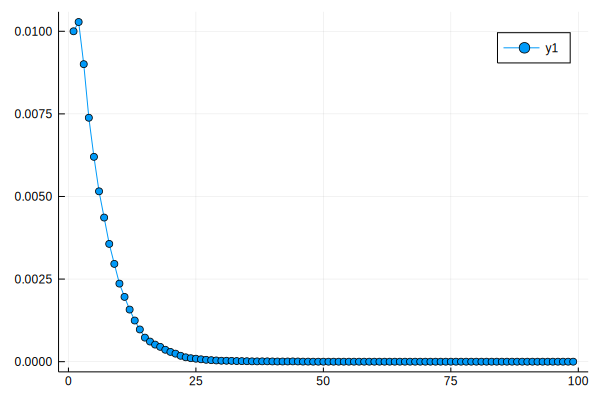

In [86]:
ts = collect(0 : 1 : t-1)

println("Final S: ", S[end])
println("Final I: ", I[end])
println("Final R: ", R[end])

dR = (R - circshift(R, 1))[2 : end]

#plot(ts, [S, I, R])
plot(dR, m=:circle)

# $\lambda_c$ study 

In [30]:
N = 10^4

k = 8

beta = 0.3

alpha = 1

I_0 = 0.01

N_inf = Int(N * I_0)

mu = 1

lambda_SIS = 0.1
lambda_SIR = 0.2

t = 100
times = 10

prob = "Single"

alphas = 1 : 0.5 : 10

lambdas = collect(0.01 : 0.01 : 0.15)

@time lambda_study_WS_SIR(alphas, lambdas, N, N_inf, k, beta, alpha, mu, t, times, prob)

  4.097255 seconds (1.43 M allocations: 175.315 MiB, 1.06% gc time)
  4.286625 seconds (1.68 M allocations: 182.947 MiB, 1.12% gc time)


# $\alpha$ study 

In [31]:
N = 10^4

k = 8

beta = 0.3

alpha = 3

I_0 = 0.01

N_inf = Int(N * I_0)

mu = 1

lambda_SIS = 0.1
lambda_SIR = 0.2

t = 100
times = 10

prob = "Uniform"

alphas = 1 : 0.5 : 10

#prevalences = @time alpha_study_WS_SIR(alphas, N, N_inf, k, beta, lambda_SIR, mu, t, times, prob);

209.761886 seconds (16.47 M allocations: 1.743 GiB, 0.35% gc time)
